# Merton Diffusion model

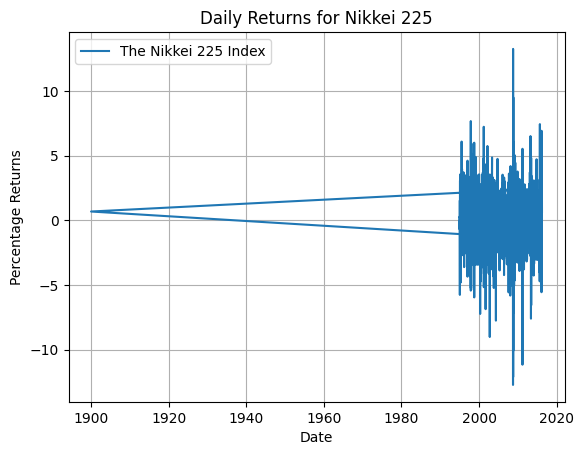

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_excel('/content/mmc2.xlsx', sheet_name=0, skiprows=1)  # Adjust column names as needed

data.columns = ['Date', 'Closing_Price', 'Percentage_Return']

# Convert Date to datetime and ensure numeric types for prices and returns
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['Closing_Price'] = pd.to_numeric(data['Closing_Price'], errors='coerce')
data['Percentage_Return'] = pd.to_numeric(data['Percentage_Return'], errors='coerce')

# Drop rows with NaN in Percentage_Return (e.g., first row)
data = data.dropna(subset=['Percentage_Return'])

plt.plot(data['Date'], data['Percentage_Return'], label='The Nikkei 225 Index')
plt.xlabel('Date')
plt.ylabel('Percentage Returns')
plt.title('Daily Returns for Nikkei 225')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.optimize import minimize
import numpy as np

def merton_log_likelihood(params, returns, dt=1/252):
    mu, sigma, lambda_, m, delta = params
    log_returns = returns
    k = np.exp(m + 0.5 * delta**2) - 1
    likelihood = 0
    for r in log_returns:
        diff_term = -0.5 * np.log(2 * np.pi * sigma**2 * dt) - (r - (mu - 0.5 * sigma**2 - lambda_ * k) * dt)**2 / (2 * sigma**2 * dt)
        jump_term = -lambda_ * dt + np.log(lambda_) - 0.5 * np.log(2 * np.pi * delta**2) - (r - m)**2 / (2 * delta**2)
        likelihood += diff_term + jump_term
    return -likelihood

returns = data['Percentage_Return'].values / 100  # Convert to decimal
initial_params = [0.05, 0.2, 10, 0, 0.1]
result = minimize(merton_log_likelihood, initial_params, args=(returns,), bounds=[(-1, 1), (0.01, 1), (0, 50), (-1, 1), (0.01, 1)])
print(f"Fitted Parameters: {result.x}")

Fitted Parameters: [ 2.75977217e-02  2.45894763e-01  5.00000000e+01 -2.85961149e-05
  1.54899091e-02]


In [ ]:
import math
from scipy.stats import norm


def merton_call_price(S0, K, T, r, sigma, lambda_, m, delta, num_terms=10):
    price = 0
    k = np.exp(m + 0.5 * delta**2) - 1
    for n in range(num_terms):
        lambda_n = lambda_ * (1 + k)
        sigma_n = np.sqrt(sigma**2 + n * delta**2 / T)
        r_n = r - lambda_ * k + n * (m + 0.5 * delta**2) / T
        d1 = (np.log(S0 / K) + (r_n + 0.5 * sigma_n**2) * T) / (sigma_n * np.sqrt(T))
        d2 = d1 - sigma_n * np.sqrt(T)
        price_n = S0 * norm.cdf(d1) - K * np.exp(-r_n * T) * norm.cdf(d2)
        price += (np.exp(-lambda_ * T) * (lambda_ * T)**n / math.factorial(n)) * price_n
    return price

# Parameters for option pricing
fitted_params = result.x
T = 1/12  # 1 month
r = 0.01  # Risk-free rate
mu, sigma, lambda_, m, delta = fitted_params

# Calculate option prices for each closing price
strike_ratios = [0.95, 1.0, 1.05]  # ITM, ATM, OTM
for ratio in strike_ratios:
    data[f'Call_Price_{int(ratio*100)}'] = data['Closing_Price'].apply(
        lambda S0: merton_call_price(S0, S0 * ratio, T, r, sigma, lambda_, m, delta)
    )

# Save results to a new Excel file
data.to_excel('nikkei225_option_prices.xlsx', index=False)
print("\nOption prices calculated and saved to 'nikkei225_option_prices.xlsx'")
print("\nFirst few rows with option prices:")
print(data[['Date', 'Closing_Price', 'Call_Price_95', 'Call_Price_100', 'Call_Price_105']].head())


Option prices calculated and saved to 'nikkei225_option_prices.xlsx'

First few rows with option prices:
        Date  Closing_Price  Call_Price_95  Call_Price_100  Call_Price_105
1 1995-01-04       19684.04    1209.455620      610.183161      253.216787
2 1995-01-05       19616.11    1205.281766      608.077408      252.342931
3 1995-01-06       19519.46    1199.343255      605.081366      251.099619
4 1995-01-09       19444.92    1194.763259      602.770710      250.140731
5 1995-01-10       19501.45    1198.236658      604.523076      250.867937


# Comparison between LSTM, GRU, Transformer and Random Forest

Estimated Jump Frequency (λ): 3.46 jumps per year (Total jumps: 71)
Training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Training GRU...

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Training Random Forest...

📊 Comparative Evaluation (with Estimated λ=3.46):
                                MAE       RMSE        R2
LSTM          Strike_95    9.856886  13.710659  0.996438
              Strike_100   4.978476   6.931597  0.996423
              Strike_105   2.066549   2.877725  0.996420
GRU           Strike_95    9.332054  13.273418  0.996662
              Strike_100   4.709720   6.715279  0.996643
              Stri

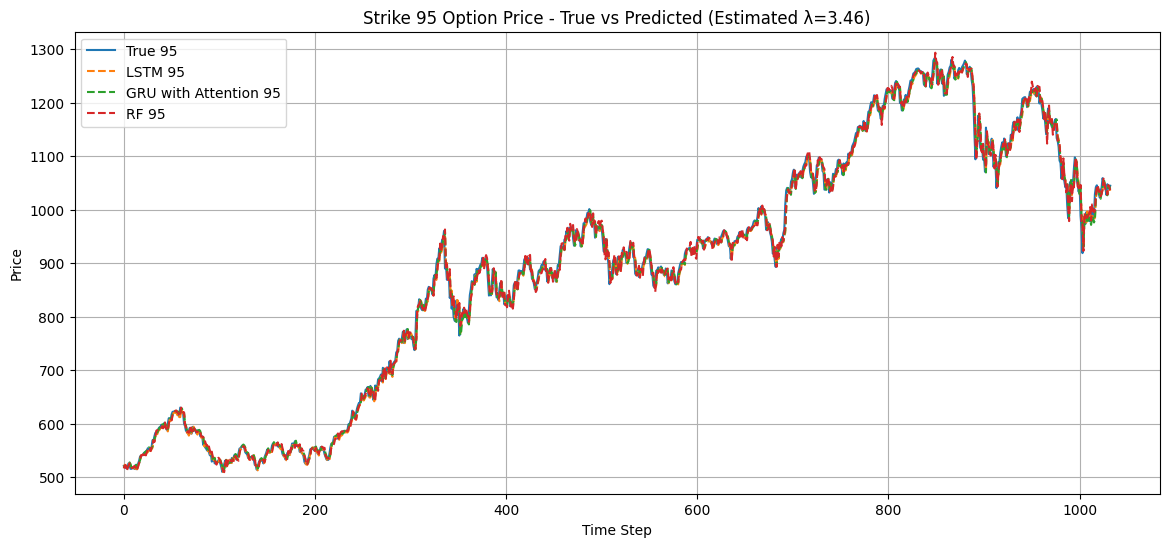

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

# 1. Statistical Inference for Jump Frequency
def estimate_jump_frequency(df, threshold_factor=3, trading_days_per_year=252):
    """
    Estimate jump frequency (lambda) based on threshold-based jump detection.
    Parameters:
    - df: DataFrame with 'Percentage_Return' column
    - threshold_factor: Number of standard deviations to define a jump
    - trading_days_per_year: Number of trading days per year
    Returns:
    - lambda_: Estimated jump frequency (jumps per year)
    - jump_count: Total number of jumps detected
    """
    return_std = df['Percentage_Return'].std()
    threshold = threshold_factor * return_std
    jumps = df[abs(df['Percentage_Return']) > threshold]
    jump_count = len(jumps)
    T = len(df) / trading_days_per_year
    lambda_ = jump_count / T if T > 0 else 0
    return lambda_, jump_count

# 2. Load and preprocess
df = pd.read_excel("nikkei225_option_prices.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Handle NaNs in input data
df = df.dropna(subset=['Closing_Price', 'Percentage_Return', 'Call_Price_95', 'Call_Price_100', 'Call_Price_105'])

# Estimate jump frequency
lambda_, jump_count = estimate_jump_frequency(df, threshold_factor=3)
print(f"Estimated Jump Frequency (λ): {lambda_:.2f} jumps per year (Total jumps: {jump_count})")

# Add jump features with NaN handling
df['Jump_Frequency'] = (abs(df['Percentage_Return']) > 3 * df['Percentage_Return'].std()).rolling(window=10, min_periods=1).sum().fillna(0)
df['Jump_Magnitude'] = df['Percentage_Return'][abs(df['Percentage_Return']) > 3 * df['Percentage_Return'].std()].rolling(window=10, min_periods=1).mean().fillna(0)
df['Jump_Volatility'] = df['Percentage_Return'][abs(df['Percentage_Return']) > 3 * df['Percentage_Return'].std()].rolling(window=10, min_periods=1).std().fillna(0)
df['Estimated_Lambda'] = lambda_

features = ['Closing_Price', 'Percentage_Return', 'Jump_Frequency', 'Jump_Magnitude', 'Jump_Volatility', 'Estimated_Lambda']
targets = ['Call_Price_95', 'Call_Price_100', 'Call_Price_105']

# Scale features and targets
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df[features])
y_scaled = target_scaler.fit_transform(df[targets])

# Check for NaNs in scaled data
if np.any(np.isnan(X_scaled)) or np.any(np.isnan(y_scaled)):
    print("Warning: NaNs found in scaled data. Imputing with zeros.")
    X_scaled = np.nan_to_num(X_scaled, nan=0.0)
    y_scaled = np.nan_to_num(y_scaled, nan=0.0)

# 3. Convert to sequences
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        seq_x = X[i:(i + time_steps)]
        seq_y = y[i + time_steps]
        if not (np.any(np.isnan(seq_x)) or np.any(np.isnan(seq_y))):
            Xs.append(seq_x)
            ys.append(seq_y)
    return np.array(Xs), np.array(ys)

time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

if len(X_seq) == 0:
    raise ValueError("No valid sequences created. Check for NaNs or insufficient data after preprocessing.")

split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# 4. Build models
def build_lstm_model():
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(32, activation='relu'),
        Dense(3)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_attention_model():
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = GRU(64, return_sequences=True)(inputs)
    x = MultiHeadAttention(num_heads=2, key_dim=8)(x, x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(3)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

callbacks = [
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
]

# 5. Train models
print("Training LSTM...")
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, callbacks=callbacks, verbose=0)
y_lstm_pred = target_scaler.inverse_transform(lstm_model.predict(X_test))

print("Training GRU...")
gru_model = build_gru_attention_model()
gru_model.fit(X_train, y_train, epochs=30, batch_size=32, callbacks=callbacks, verbose=0)
y_gru_pred = target_scaler.inverse_transform(gru_model.predict(X_test))

print("Training Random Forest...")
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)
y_rf_pred = target_scaler.inverse_transform(rf_model.predict(X_test_rf))

# 6. Evaluation
def evaluate(y_true, y_pred):
    # Ensure no NaNs in evaluation
    if np.any(np.isnan(y_true)) or np.any(np.isnan(y_pred)):
        print("Warning: NaNs found in y_true or y_pred. Imputing with zeros.")
        y_true = np.nan_to_num(y_true, nan=0.0)
        y_pred = np.nan_to_num(y_pred, nan=0.0)
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

y_true = target_scaler.inverse_transform(y_test)
models = {
    'LSTM': y_lstm_pred,
    'GRU': y_gru_pred,
    'Random Forest': y_rf_pred
}

results = {}
for name, y_pred in models.items():
    res = [evaluate(y_true[:, i], y_pred[:, i]) for i in range(3)]
    results[name] = pd.DataFrame(res, index=['Strike_95', 'Strike_100', 'Strike_105'])

final_comparison = pd.concat(results, axis=0)
print("\n📊 Comparative Evaluation (with Estimated λ={:.2f}):".format(lambda_))
print(final_comparison)


# 7. Optional: Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(y_true[:, 0], label='True 95')
plt.plot(y_lstm_pred[:, 0], '--', label='LSTM 95')
plt.plot(y_gru_pred[:, 0], '--', label='GRU with Attention 95')
plt.plot(y_rf_pred[:, 0], '--', label='RF 95')
plt.legend()
plt.title(f"Strike 95 Option Price - True vs Predicted (Estimated λ={lambda_:.2f})")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [ ]:
# 7. Save predictions to Excel
def save_predictions_to_excel(y_true, y_lstm_pred, y_gru_pred, y_rf_pred, lambda_, filename='option_price_predictions_with_statistical_jumps.xlsx'):
    # Ensure no NaNs in predictions
    y_true = np.nan_to_num(y_true, nan=0.0)
    y_lstm_pred = np.nan_to_num(y_lstm_pred, nan=0.0)
    y_gru_pred = np.nan_to_num(y_gru_pred, nan=0.0)
    y_rf_pred = np.nan_to_num(y_rf_pred, nan=0.0)

    pred_df = pd.DataFrame({
        'Date': df['Date'].iloc[-len(y_true):].reset_index(drop=True),
        'True_95': y_true[:, 0],
        'LSTM_95': y_lstm_pred[:, 0],
        'GRU_95': y_gru_pred[:, 0],
        'RF_95': y_rf_pred[:, 0],
        'True_100': y_true[:, 1],
        'LSTM_100': y_lstm_pred[:, 1],
        'GRU_100': y_gru_pred[:, 1],
        'RF_100': y_rf_pred[:, 1],
        'True_105': y_true[:, 2],
        'LSTM_105': y_lstm_pred[:, 2],
        'GRU_105': y_gru_pred[:, 2],
        'RF_105': y_rf_pred[:, 2],
        'Estimated_Lambda': lambda_
    })

    metrics_df = final_comparison.reset_index()
    metrics_df['Estimated_Lambda'] = lambda_

    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        pred_df.to_excel(writer, sheet_name='Predictions', index=False)
        metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

    print(f"\nPredictions and metrics saved to {filename}")

save_predictions_to_excel(y_true, y_lstm_pred, y_gru_pred, y_rf_pred, lambda_)


Predictions and metrics saved to option_price_predictions_with_statistical_jumps.xlsx


# Using Neural SDE (SOTA Analysis )

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the dataset
def load_data(file_path):
    df = pd.read_excel(file_path)
    dates = df['Date'].values
    prices = df['Closing_Price'].values.reshape(-1, 1)  # Ensure 2D array

    # Normalize prices
    scaler = MinMaxScaler()
    prices_normalized = scaler.fit_transform(prices)

    # Create sequences
    seq_length = 20
    X, y = [], []
    for i in range(len(prices_normalized) - seq_length):
        X.append(prices_normalized[i:i+seq_length])
        y.append(prices_normalized[i+seq_length])
    X = np.array(X)
    y = np.array(y)

    # Split into train and test
    train_size = int(0.8 * len(X))
    X_train = torch.tensor(X[:train_size], dtype=torch.float32)
    y_train = torch.tensor(y[:train_size], dtype=torch.float32)
    X_test = torch.tensor(X[train_size:], dtype=torch.float32)
    y_test = torch.tensor(y[train_size:], dtype=torch.float32)

    return X_train, y_train, X_test, y_test, scaler, dates[train_size+seq_length:]

# Neural network to predict MJD parameters
class ParameterNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=5):
        super(ParameterNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step
        # Ensure valid parameter ranges
        mu = self.relu(out[:, 0])  # Drift
        sigma = self.sigmoid(out[:, 1]) * 0.5 + 0.01  # Volatility
        lam = self.sigmoid(out[:, 2]) * 1.0  # Jump intensity
        mu_J = self.relu(out[:, 3])  # Jump mean
        sigma_J = self.sigmoid(out[:, 4]) * 0.5 + 0.01  # Jump volatility
        return torch.stack([mu, sigma, lam, mu_J, sigma_J], dim=1)

# Euler-Maruyama with restart for MJD simulation
def euler_maruyama_restart(x0, params, dt, n_steps, restart_interval):
    batch_size = x0.shape[0]
    x = x0.clone()

    for t in range(n_steps):
        # Extract parameters for the batch
        mu = params[:, 0]
        sigma = params[:, 1]
        lam = params[:, 2]
        mu_J = params[:, 3]
        sigma_J = params[:, 4]

        # Wiener process increment
        dW = torch.normal(0, np.sqrt(dt), size=(batch_size,)).to(x0.device)

        # Poisson process for jumps (batched)
        n_jumps = torch.poisson(lam * dt)
        max_jumps = int(n_jumps.max().item()) if n_jumps.max() > 0 else 1
        # Generate jump sizes using randn for batched normal sampling
        jump_sizes = mu_J.unsqueeze(1) + sigma_J.unsqueeze(1) * torch.randn(batch_size, max_jumps).to(x0.device)
        jump_mask = torch.arange(max_jumps).to(x0.device) < n_jumps.unsqueeze(1)
        jumps = torch.sum(jump_sizes * jump_mask.float(), dim=1)

        # Euler-Maruyama step
        x = x + mu * x * dt + sigma * x * dW + x * jumps

        # Restart: inject analytical mean periodically
        if (t + 1) % restart_interval == 0:
            x = x * 0.5 + torch.mean(x) * 0.5  # Scalar mean for simplicity

    return x

# Neural MJD model
class NeuralMJD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=5):
        super(NeuralMJD, self).__init__()
        self.param_net = ParameterNet(input_size, hidden_size, output_size)

    def forward(self, x, dt=1/252, n_steps=1, restart_interval=5):
        params = self.param_net(x)
        x0 = x[:, -1, 0]  # Last price in the sequence
        x_pred = euler_maruyama_restart(x0, params, dt, n_steps, restart_interval)
        return x_pred.unsqueeze(1)  # Match y_train shape (batch_size, 1)

# Training function
def train_model(model, X_train, y_train, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

    return losses

# Evaluation function
def evaluate_model(model, X_test, y_test, scaler, dates):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    # Ensure 2D arrays for inverse_transform
    y_test_np = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_np = scaler.inverse_transform(y_pred.squeeze().numpy().reshape(-1, 1))

    # Calculate adjusted R^2
    r2 = r2_score(y_test_np, y_pred_np)
    adj_r2 = 1 - (1 - r2) * (len(y_test_np) - 1) / (len(y_test_np) - X_test.shape[2] - 1)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test_np, label='Actual')
    plt.plot(dates, y_pred_np, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'Neural MJD Predictions (Adjusted R²: {adj_r2:.6f})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('neural_mjd_predictions.png')
    plt.close()

    return adj_r2

# Main execution
def main():
    # Load data
    file_path = 'nikkei225_option_prices.xlsx'
    X_train, y_train, X_test, y_test, scaler, dates = load_data(file_path)

    # Initialize model
    input_size = 1  # Closing price only
    hidden_size = 64
    output_size = 5  # mu, sigma, lambda, mu_J, sigma_J
    model = NeuralMJD(input_size, hidden_size, output_size)

    # Train model
    losses = train_model(model, X_train, y_train, epochs=100)

    # Evaluate model
    adj_r2 = evaluate_model(model, X_test, y_test, scaler, dates)
    print(f'Adjusted R² on test set: {adj_r2:.4f}')

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss')
    plt.savefig('training_loss.png')
    plt.close()

if __name__ == '__main__':
    main()

Epoch 10/100, Loss: 0.000315
Epoch 20/100, Loss: 0.000275
Epoch 30/100, Loss: 0.000234
Epoch 40/100, Loss: 0.000192
Epoch 50/100, Loss: 0.000178
Epoch 60/100, Loss: 0.000175
Epoch 70/100, Loss: 0.000175
Epoch 80/100, Loss: 0.000175
Epoch 90/100, Loss: 0.000175
Epoch 100/100, Loss: 0.000175
Adjusted R² on test set: 0.9966
